In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from momaapi import MOMA
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [8]:
moma = MOMA(dir_moma="/data/dir_moma/", paradigm="few-shot")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

In [10]:
def cosine_mean_similarity(x, y):
    # x: n x d
    # y: m x d
    # assume that x, y are not normalized
    
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    
    return torch.mm(x, y.t()).mean()

def smooth_chamfer_similarity(x, y, alpha):
    # x: n x d
    # y: m x d
    # assume that x, y are not normalized
    
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    c = torch.mm(x, y.t())
    
    left_term = torch.logsumexp(alpha*c, dim=1).sum() / (2.*alpha*x.shape[0])
    right_term = torch.logsumexp(alpha*c, dim=0).sum() / (2.*alpha*y.shape[0])
    
    return left_term + right_term

In [4]:
# 기존의 방법

cache = {}
ids_act = moma.get_ids_act(split="val")
for act in tqdm(moma.get_anns_act(ids_act)):
    captions = []
    for sact in moma.get_anns_sact(act.ids_sact):
        if captions and sact.cname == captions[-1]:
            continue
        captions.append(sact.cname)
        
    with torch.no_grad():
        embeddings = sbert_model.encode(captions)
        cache[act.id] = torch.from_numpy(embeddings)

100%|██████████| 399/399 [00:18<00:00, 21.99it/s]


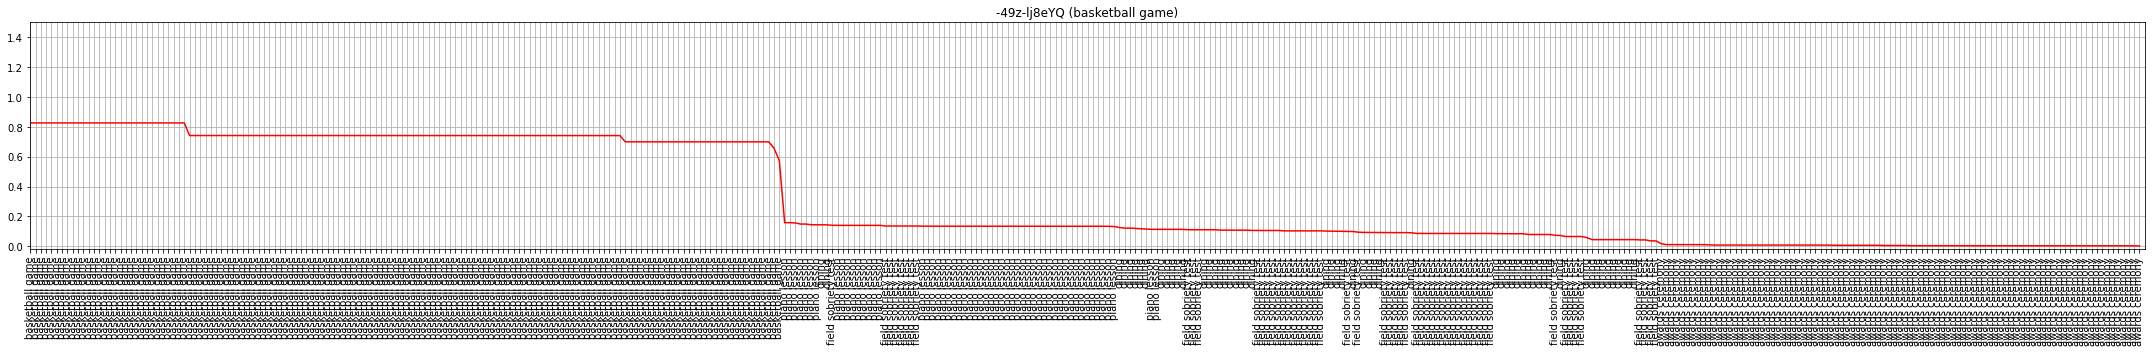

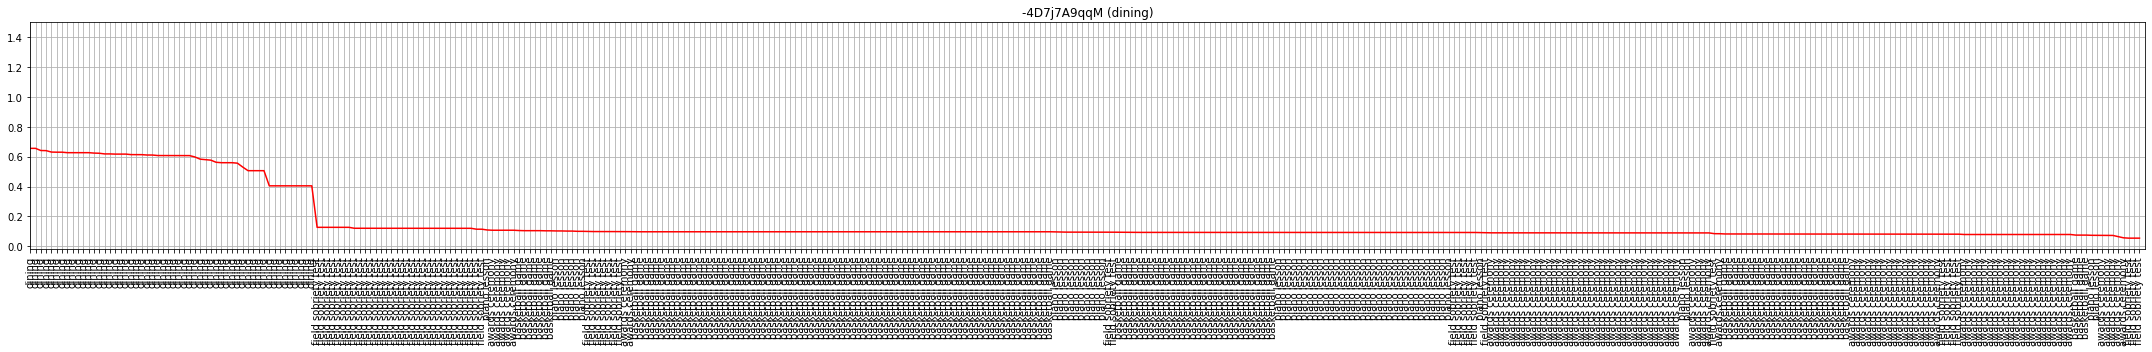

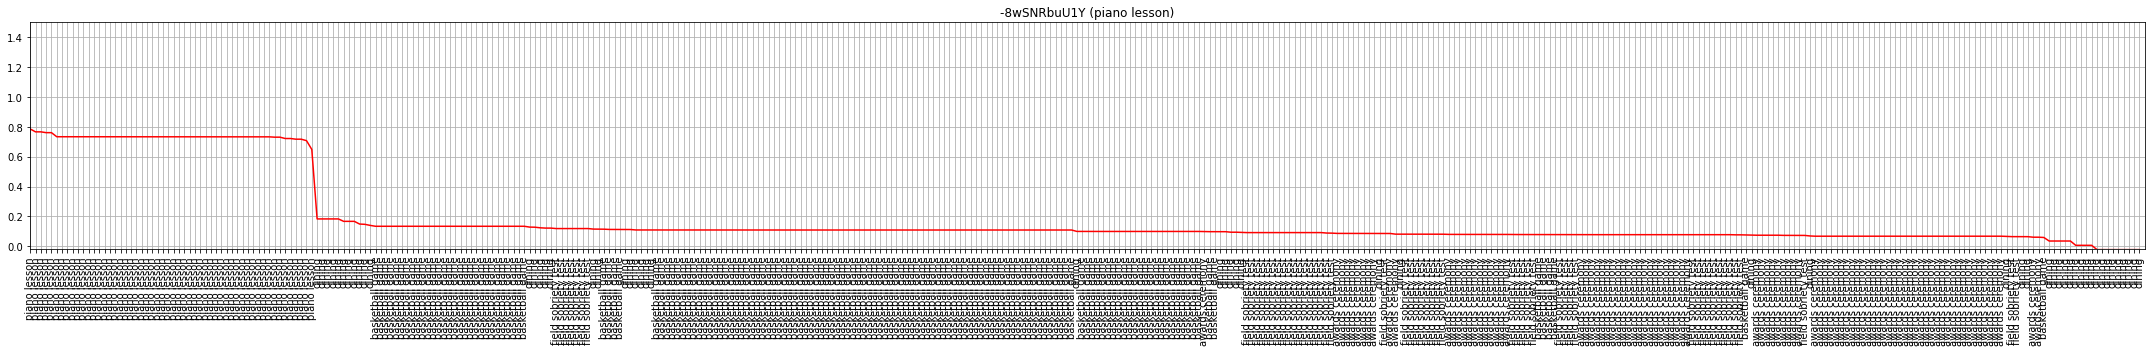

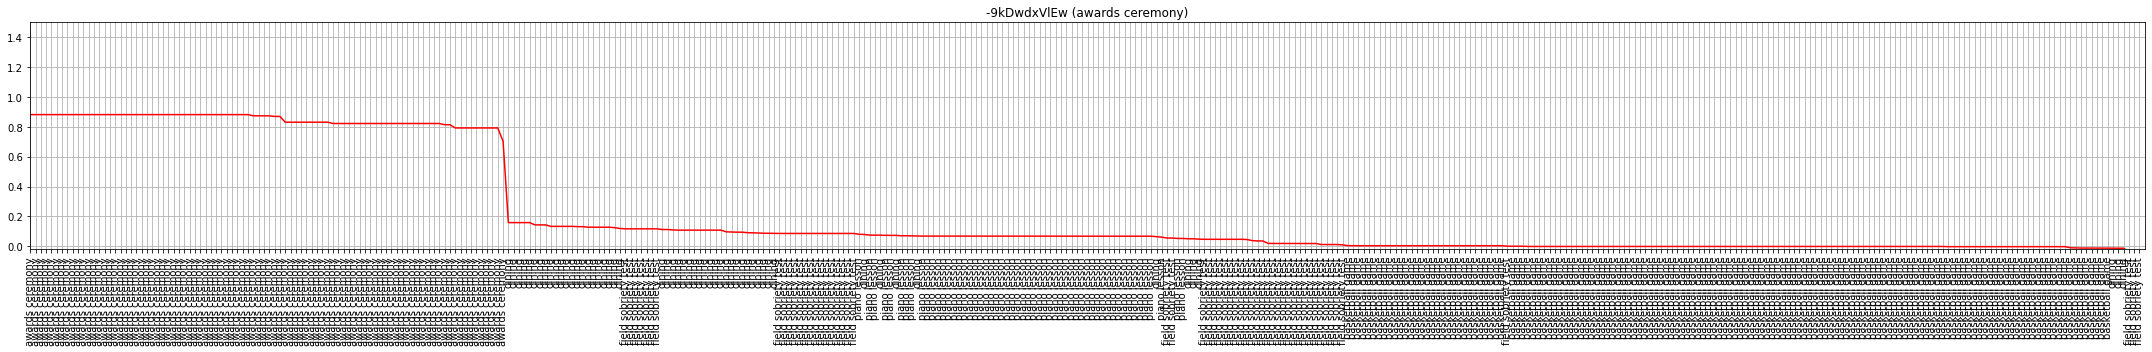

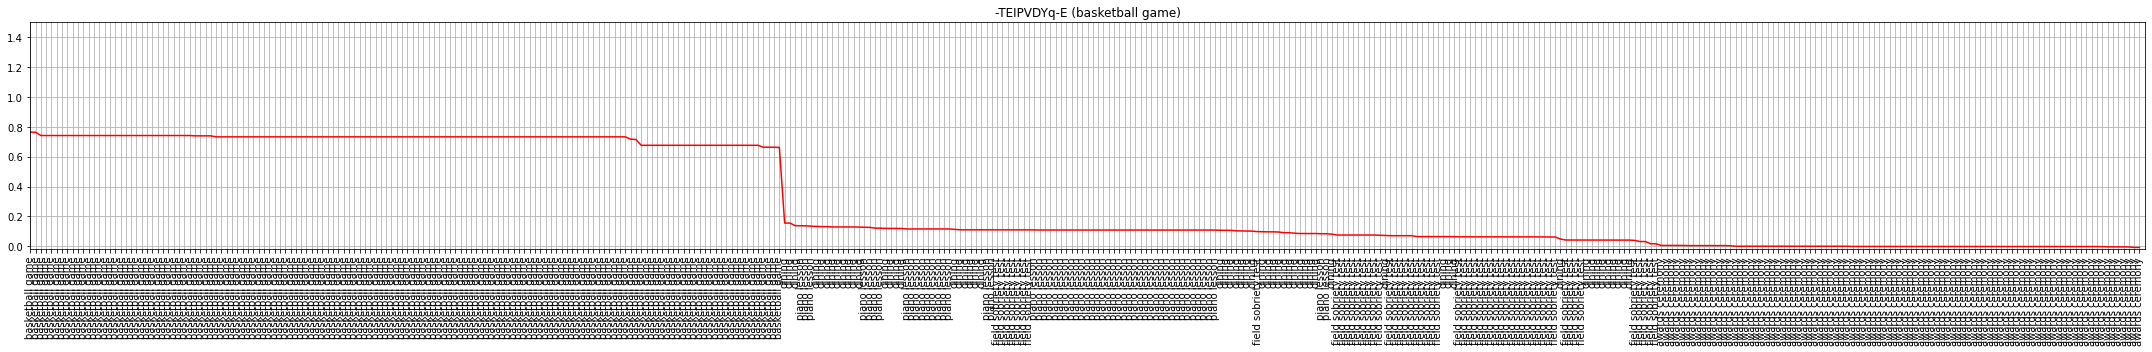

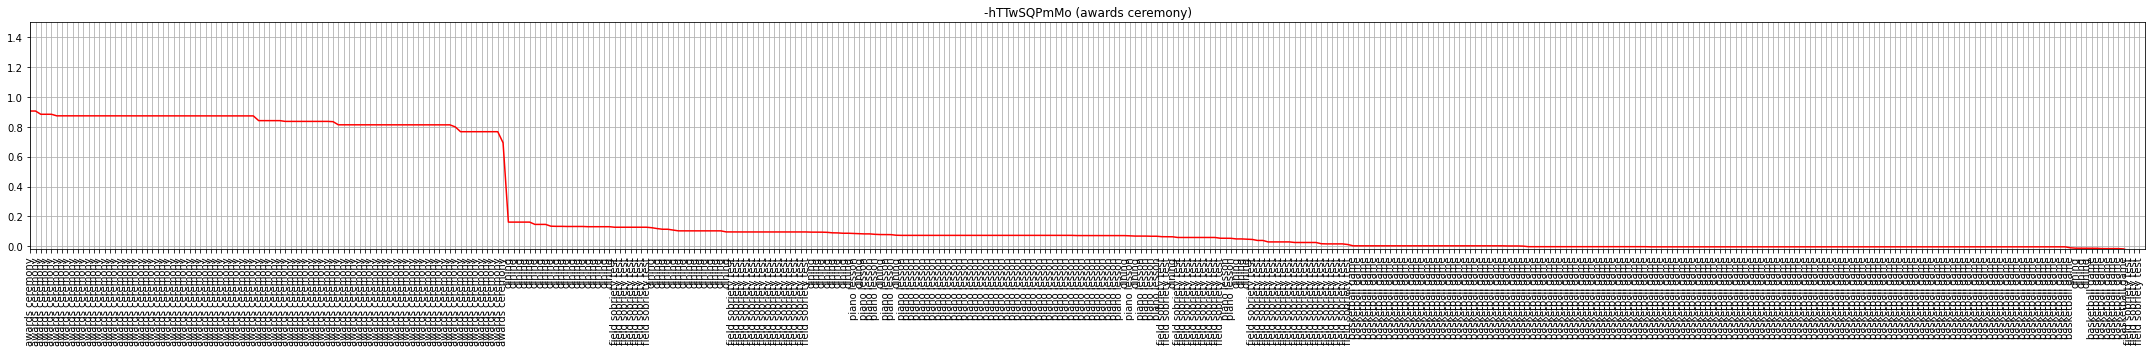

In [13]:
for i, act_q in enumerate(moma.get_anns_act(ids_act)):
    q_emb = cache[act_q.id]
    ref_embs, x_label = [], []
    for act_r in moma.get_anns_act(ids_act):
        if act_q.id == act_r.id:
            continue
        ref_embs.append(cache[act_r.id])
        x_label.append(act_r.cname)

    relevances = []
    for r_emb in ref_embs:
        relevances.append(cosine_mean_similarity(q_emb, r_emb))
        # relevances.append(smooth_chamfer_similarity(q_emb, r_emb, 16))
    relevances = torch.stack(relevances)

    sorted_relevances, sorted_idx = torch.sort(relevances, descending=True)
    sorted_relevances = sorted_relevances.cpu().numpy()
    x_label = [x_label[idx] for idx in sorted_idx]

    plt.figure(figsize=(30, 5))
    plt.title(f"{act_q.id} ({act_q.cname})")
    plt.xticks(np.arange(len(x_label)), label=x_label, rotation=90)
    plt.gca().set_xticklabels(x_label)
    plt.xlim([0, len(x_label)])
    plt.ylim([-0.02, 1.5])
    plt.grid(True)
    plt.tight_layout()

    plt.plot(np.arange(len(sorted_relevances)), sorted_relevances, color="red")

    plt.show()

    if i == 5:
        break